In [1]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension("collapsible_headings/main")

<IPython.core.display.Javascript object>

In [2]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (
    LinearRegression,
    PoissonRegressor,
    GammaRegressor,
    HuberRegressor,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Import datasets
from doubt.datasets import (
    Airfoil,
    Blog,
    Concrete,
    CPU,
    FacebookComments,
    FishBioconcentration,
    FishToxicity,
    ForestFire,
    NewTaipeiHousing,
    PowerPlant,
    Protein,
    Servo,
    SpaceShuttle,
    Yacht,
)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt
import itertools
from matplotlib import rcParams

%matplotlib inline
plt.style.use("seaborn-whitegrid")
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12
rcParams["figure.figsize"] = 16, 8

plt.style.use("ggplot")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from collections import defaultdict
import seaborn as sns
import pdb

sns.set_theme(style="whitegrid")
import shap

# Import internal classes
from distributions import DistributionShift
from src.psi import psi
import warnings

warnings.filterwarnings("ignore")

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from category_encoders import MEstimateEncoder

In [4]:
df = pd.read_csv("data/trainclean.csv")
df = df.drop(columns="Id")

df["random"] = np.random.random(df.shape[0])
df["random"].mean()

0.4995785233721692

In [5]:
df = df[
    [
        "OverallQual",
        "GrLivArea",
        "TotalBsmtSF",
        "ExterQual",
        "KitchenQual",
        "LotFrontage",
        # "LotArea",
        "SalePrice",
        "random",
    ]
]

In [6]:
def explain(xgb: bool = True):
    """
    Provide a SHAP explanation by fitting MEstimate and GBDT
    """
    if xgb:
        pipe = Pipeline(
            [("encoder", MEstimateEncoder()), ("model", GradientBoostingRegressor())]
        )
        pipe.fit(X, y)
        explainer = shap.Explainer(pipe[1])
        shap_values = explainer(pipe[:-1].transform(X))
        shap.plots.beeswarm(shap_values)
        return pd.DataFrame(np.abs(shap_values.values), columns=X.columns).sum()
    else:
        pipe = Pipeline(
            [("encoder", MEstimateEncoder()), ("model", LogisticRegression())]
        )
        pipe.fit(X, y)
        coefficients = pd.concat(
            [pd.DataFrame(X_tr.columns), pd.DataFrame(np.transpose(pipe[1].coef_))],
            axis=1,
        )
        coefficients.columns = ["feat", "val"]

        return coefficients.sort_values(by="val", ascending=False)

In [7]:
y = df["SalePrice"]
X = df.drop(columns="SalePrice")._get_numeric_data()

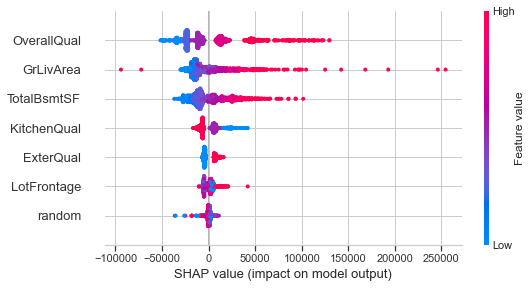

OverallQual    3.687603e+07
GrLivArea      2.508559e+07
TotalBsmtSF    2.336040e+07
ExterQual      8.175652e+06
KitchenQual    1.202443e+07
LotFrontage    5.167297e+06
random         2.326506e+06
dtype: float64

In [8]:
explain()

# Synthetic Data

In [11]:
def explainability_plot(
    base_regressor: type,
    dataset: type,
    shift_param: int,
    test_size: int = 0.3,
    n_boots: int = 20,
    different_feature: int = None,
    **kwargs
):

    y = dataset["SalePrice"]
    X = dataset.drop(columns="SalePrice")._get_numeric_data()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0, test_size=0.3
    )

    # Scale the dataset
    standard_scaler = StandardScaler()
    standard_scaler.fit(X_train)
    X_train = pd.DataFrame(standard_scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(standard_scaler.transform(X_test), columns=X_train.columns)

    # Initialize Shifter
    shifter = DistributionShift()
    shifter.fit(X_train)

    # Fit the regressor
    regressor = Boot(base_regressor(**kwargs))
    regressor.fit(X_train, y_train, n_boots=n_boots)
    ## Evaluate the regressor
    print("Regressor r2: ", r2_score(regressor.predict(X_test), y_test))

    # Transform the test
    shifter.set_params(param=shift_param, cols=["random", "GrLivArea", "TotalBsmtSF"])
    new_X_test = shifter.transform(X_test)

    # Predict uncertainty
    predictions, intervals = regressor.predict(new_X_test, uncertainty=0.05, n_boots=20)
    uncertainty = intervals[:, 1] - intervals[:, 0]

    # Explainability
    exp = CatBoostRegressor(iterations=200, verbose=0)
    exp.fit(X_test, uncertainty)
    print("xAI r2: ", r2_score(exp.predict(X_test), uncertainty))
    explainer = shap.Explainer(exp)
    shap_values = explainer(new_X_test)

    # Plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

    fig.suptitle("Identifying the source of model degradation bt train and test")

    ## Plot PSI
    ### Data Wrangling
    psi_dic = []
    for col in X_train.columns:
        psi_dic.append(
            [
                col,
                psi(X_train[col], new_X_test[col]),
                ks_2samp(X_train[col], new_X_test[col]).statistic,
            ]
        )
    psi_dic = pd.DataFrame(psi_dic, columns=["column", "psi", "ks"])

    ### Figure PSI
    ax1.title.set_text("Population Stability Index")
    ax1.set_ylabel("Population Stability Index")
    keys = psi_dic.sort_values("psi").column.values
    values = psi_dic.sort_values("psi").psi.values
    ax1.barh(keys, values)

    ### Figure KS
    ax2.title.set_text("Kolmogorov-Smirnov")
    ax2.set_ylabel("Kolmogorov-Smirnov")
    keys = psi_dic.sort_values("ks").column.values
    values = psi_dic.sort_values("ks").ks.values
    ax2.barh(keys, values)

    ### Plot Shap
    ax3 = shap.plots.bar(shap_values, show=False)
    plt.tight_layout()
    plt.savefig("experiments/xai/shap_comparison.eps", format="eps")
    plt.show()

    ## Plot summary Shap
    # summarize the effects of all the features
    plt.figure()
    shap.plots.beeswarm(shap_values)
    plt.show()

    ## Shap waterfall,
    plt.figure()
    plt.title("Local explanation with shap values for a particular instance")
    shap.plots.waterfall(shap_values[1], show=False)
    plt.tight_layout()
    plt.savefig("experiments/xai/local_shap.eps", format="eps")
    plt.show()

Regressor r2:  0.8261653720250731
xAI r2:  0.9982532423275179


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


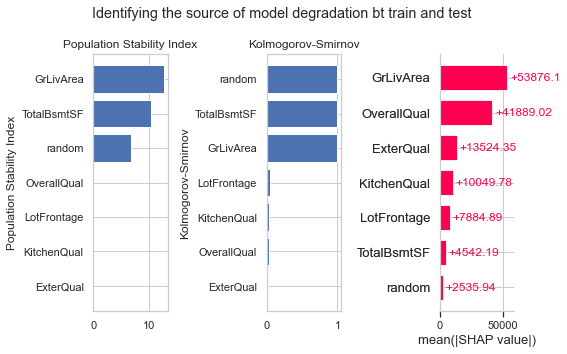

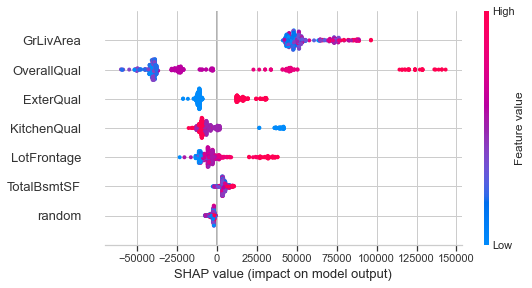

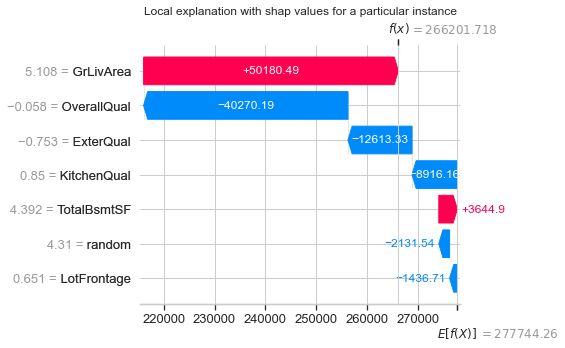

In [15]:
explainability_plot(
    dataset=df,
    base_regressor=XGBRegressor,
    shift_param=5,
    n_boots=20,
    test_size=0.3,
)